<H1>Testing inhibitory motifs</H1>

In [1]:
# loading python modules
import numpy as np
np.random.seed(0)

from matplotlib.pyplot import figure
from terminaltables import AsciiTable 

from __future__ import division

In [2]:
# loading custom inet modules
from inet import DataLoader
from inet.motifs import iicounter, motifcounter
from inet.utils import chem_squarematrix, elec_squarematrix

In [3]:
# use the dataset to create the null hypothesis
mydataset = DataLoader('../data/PV')

 168 syn  files loaded


<H2>Collect number of experiments containing PV(+) cells</H2>

In [4]:
# e.g. mydataset.PV[2].values  will return the different configurations with 2 PV cells
nPV = range(9)
for i in nPV:
    nPV[i] = np.sum(mydataset.IN[i].values())
    nPV[i] = np.sum(mydataset.IN[i].values())

In [5]:
nPV

[0, 145, 21, 2, 0, 0, 0, 0, 0]

In [6]:
# for the moment, we only count experiments with 2 or 3 PVs
# later we use mydataset.PV[2:]
PV2 = sum(mydataset.IN[2].values())
PV3 = sum(mydataset.IN[3].values())
PV2, PV3

(21, 2)

<H2> Calculate empirical probabilities </H2>

In [7]:
PC = mydataset.motif.ii_chem_found/mydataset.motif.ii_chem_tested
PE = mydataset.motif.ii_elec_found/mydataset.motif.ii_elec_tested

PC2  = mydataset.motif.ii_c2_found/mydataset.motif.ii_c2_tested
Pdiv = mydataset.motif.ii_div_found/mydataset.motif.ii_div_tested
Pcon = mydataset.motif.ii_con_found/mydataset.motif.ii_con_tested
Pchain = mydataset.motif.ii_chain_found/mydataset.motif.ii_chain_tested

PC1E = mydataset.motif.ii_c1e_found/mydataset.motif.ii_c1e_tested
PC2E = mydataset.motif.ii_c2e_found/mydataset.motif.ii_c2e_tested



info = [
    ['key', 'Probability', 'Motif', 'Value'],
    ['ii_chem', 'P(C)', 'chemical synapse',PC ],
    ['ii_elec', 'P(E)', 'electrical synapse',PE ],
    ['','',''],
    ['ii_c2', 'P(C U C)','bidirectional chemical synapse',PC2],
    ['ii_con', 'Pcon', 'convergent inhibitory motifs', Pcon],
    ['ii_div', 'Pdiv', 'divergent inhibitory motifs', Pdiv],
    ['ii_chain', 'Pchain', 'linear inhibitory motifs', Pchain],
    ['',''],
    ['ii_c1e', 'P(C U E)', 'electrical and unidirectional chemical', PC1E],
    ['ii_c2e', 'P(2C U E):','electrical and bidirectional chemical', PC2E],

]
print(AsciiTable(info).table)

+----------+-------------+----------------------------------------+----------------+
| key      | Probability | Motif                                  | Value          |
+----------+-------------+----------------------------------------+----------------+
| ii_chem  | P(C)        | chemical synapse                       | 0.296296296296 |
| ii_elec  | P(E)        | electrical synapse                     | 0.481481481481 |
|          |             |                                        |                |
| ii_c2    | P(C U C)    | bidirectional chemical synapse         | 0.148148148148 |
| ii_con   | Pcon        | convergent inhibitory motifs           | 0.0            |
| ii_div   | Pdiv        | divergent inhibitory motifs            | 0.166666666667 |
| ii_chain | Pchain      | linear inhibitory motifs               | 0.0            |
|          |             |                                        |                |
| ii_c1e   | P(C U E)    | electrical and unidirectional chemical

<H2> Simulate random chemical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.


In [8]:
def mychem_simulation():
    """
    simulate inhibitory chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(chem_squarematrix(size=2,prob = PC))

    for _ in range(PV3):
        mycount += iicounter(chem_squarematrix(size=3, prob = PC))
        
    return(mycount)

In [9]:
print(mychem_simulation()) # one simulation, test the number of connection tested

+----------+-------+--------+
| Motif    | found | tested |
+----------+-------+--------+
| ii_c1e   | 0     | 54     |
| ii_c2    | 2     | 27     |
| ii_c2e   | 0     | 27     |
| ii_chain | 1     | 6      |
| ii_chem  | 11    | 54     |
| ii_con   | 0     | 6      |
| ii_div   | 1     | 6      |
| ii_elec  | 0     | 27     |
+----------+-------+--------+



In [10]:
# must contain the same number of tested connections
for key in mychem_simulation().keys():
    print(key, mydataset.motif[key])


('ii_chem', {'tested': 54, 'found': 16})
('ii_c1e', {'tested': 54, 'found': 8})
('ii_div', {'tested': 6, 'found': 1})
('ii_c2e', {'tested': 27, 'found': 3})
('ii_elec', {'tested': 27, 'found': 13})
('ii_chain', {'tested': 6, 'found': 0})
('ii_con', {'tested': 6, 'found': 0})
('ii_c2', {'tested': 27, 'found': 4})


In [11]:
# simulate the whole data set 1,000 times
n_chem = list()

n_bichem = list()
n_div = list()
n_con = list()
n_chain = list()

for _ in range(1000):
    syn_counter = mychem_simulation()
    n_chem.append(syn_counter['ii_chem']['found']) # null hypothesis
    
    n_bichem.append(syn_counter['ii_c2']['found'])    
    n_con.append(syn_counter['ii_con']['found'])
    n_div.append(syn_counter['ii_div']['found'])
    n_chain.append(syn_counter['ii_chain']['found'])

If the null hypothesis is correctly implemented, we should see almost the same 
number of chemical synases as in the experiments.

In [12]:
np.mean(n_chem) # on average the same number of unidirectional connections


16.135000000000002

In [13]:
mydataset.motif['ii_chem']['found']

16

If we found a number which is different form the empirical, we must revise our 
null hypothese.

In [14]:
np.mean(n_bichem) # on average the same number of bidirectional connections????

2.3799999999999999

Define analiticaly the null hypothese:

In [15]:
PC*PC*mydataset.motif['ii_c2']['tested'] # null hypothesis

2.3703703703703702

In [16]:
mydataset.motif['ii_c2']['found'] # however, we found more empirically

4

In [17]:
# Number of divergent connections found should be very similar to the ones calculates
np.mean(n_div)

0.52600000000000002

In [18]:
PC*PC*mydataset.motif['ii_div']['tested'] # null hypothesis

0.5267489711934156

In [19]:
np.mean(n_con)

0.56599999999999995

In [20]:
PC*PC*mydataset.motif['ii_con']['tested'] # null hypothesis

0.5267489711934156

<H2> Simulate random electrical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.

In [21]:
def myelec_simulation():
    """
    simulate inhibitory electrical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(elec_squarematrix(size=2,prob = PE))

    for _ in range(PV3):
        mycount += iicounter(elec_squarematrix(size=3, prob = PE))
        
    return(mycount)

In [22]:
print(myelec_simulation()) # one simulation, test the number of connection tested

+----------+-------+--------+
| Motif    | found | tested |
+----------+-------+--------+
| ii_c1e   | 0     | 54     |
| ii_c2    | 0     | 27     |
| ii_c2e   | 0     | 27     |
| ii_chain | 0     | 6      |
| ii_chem  | 0     | 54     |
| ii_con   | 0     | 6      |
| ii_div   | 0     | 6      |
| ii_elec  | 16    | 27     |
+----------+-------+--------+



In [23]:
# must contain the same number of tested connections
for key in myelec_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 54, 'found': 16})
('ii_c1e', {'tested': 54, 'found': 8})
('ii_div', {'tested': 6, 'found': 1})
('ii_c2e', {'tested': 27, 'found': 3})
('ii_elec', {'tested': 27, 'found': 13})
('ii_chain', {'tested': 6, 'found': 0})
('ii_con', {'tested': 6, 'found': 0})
('ii_c2', {'tested': 27, 'found': 4})


In [24]:
n_elec = list()
for _ in range(1000):
    syn_elec = myelec_simulation()
    n_elec.append(syn_elec['ii_elec']['found'])

Similarly, we must see almost the same 
number of electrical connections as with the experiments

In [25]:
np.mean(n_elec)

12.949999999999999

In [26]:
mydataset.motif.ii_elec_found # voila!

13

<H2>Simulate electrical and chemical synapses independently</H2>

In [27]:
C = chem_squarematrix(size = 2, prob = PC)
E = elec_squarematrix(size = 2, prob = PE)
C + E # when a chemical (1) and electrical (2) synapse add , they have the motif 3

array([[0, 3],
       [0, 0]])

In [28]:
def myii_simulation():
    """
    simulate inhibitory electrical and chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        C = chem_squarematrix(size = 2, prob = PC)
        E = elec_squarematrix(size = 2, prob = PE)
        
        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    for _ in range(PV3):
        C = chem_squarematrix(size = 3, prob = PC)
        E = elec_squarematrix(size = 3, prob = PE)

        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    return(mycount)

In [29]:
myii_simulation()# one simulation, again, test the number of connections tested

{'ii_c1e': {'found': 6, 'tested': 54},
 'ii_c2': {'found': 2, 'tested': 27},
 'ii_c2e': {'found': 0, 'tested': 27},
 'ii_chain': {'found': 1, 'tested': 6},
 'ii_chem': {'found': 13, 'tested': 54},
 'ii_con': {'found': 1, 'tested': 6},
 'ii_div': {'found': 0, 'tested': 6},
 'ii_elec': {'found': 12, 'tested': 27}}

In [30]:
# must contain the same number of tested connections
for key in myii_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 54, 'found': 16})
('ii_c1e', {'tested': 54, 'found': 8})
('ii_div', {'tested': 6, 'found': 1})
('ii_c2e', {'tested': 27, 'found': 3})
('ii_elec', {'tested': 27, 'found': 13})
('ii_chain', {'tested': 6, 'found': 0})
('ii_con', {'tested': 6, 'found': 0})
('ii_c2', {'tested': 27, 'found': 4})


In [31]:
# simulate the whole data set 1,000 times
n_chem = list()
n_elec = list()

n_c1e = list()
n_c2e = list()

n_c2 = list()
n_div = list()
n_con = list()
n_chain = list()

for _ in range(1000):
    syn_counter = myii_simulation()
    n_chem.append( syn_counter['ii_chem']['found'] ) # null hypothesis
    n_elec.append( syn_counter['ii_elec']['found'] ) # null hypothesis
    
    n_c1e.append( syn_counter['ii_c1e']['found'] )
    n_c2e.append( syn_counter['ii_c2e']['found'] )
    
    n_c2.append( syn_counter['ii_c2']['found'])
    n_con.append( syn_counter['ii_div']['found'])
    n_div.append( syn_counter['ii_div']['found'])
    n_chain.append( syn_counter['ii_chain']['found'])

In [32]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical'], 
    ['chemical', np.mean(n_chem),  mydataset.motif['ii_chem']['found']],
    ['electrical', np.mean(n_elec),  mydataset.motif['ii_elec']['found']],
    [''],
    ['2 chem',np.mean(n_c2),mydataset.motif['ii_c2']['found']],
    ['convergent', np.mean(n_con), mydataset.motif['ii_con']['found']],
    ['divergent', np.mean(n_div), mydataset.motif['ii_div']['found']],
    ['chains', np.mean(n_chain), mydataset.motif['ii_chain']['found']],
    [''],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif['ii_c1e']['found']],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif['ii_c2e']['found']],
     ]
print(AsciiTable(info).table)

+---------------+-------------+-----------+
| Syn Motif     | Simulations | Empirical |
+---------------+-------------+-----------+
| chemical      | 15.695      | 16        |
| electrical    | 13.1        | 13        |
|               |             |           |
| 2 chem        | 2.302       | 4         |
| convergent    | 0.504       | 0         |
| divergent     | 0.504       | 1         |
| chains        | 1.027       | 0         |
|               |             |           |
| 1 chem + elec | 7.725       | 8         |
| 2 chem + elec | 1.121       | 3         |
+---------------+-------------+-----------+


Let's see if the connections found correspond to the theoretical values for the complex motifs. 


<H3>ii_c2: bidirectional chemical connections</H3>

In [33]:
mydataset.motif['ii_c2']

{'found': 4, 'tested': 27}

In [34]:
PC1 = mydataset.motif.ii_chem_found /mydataset.motif.ii_chem_tested
PC1

0.2962962962962963

In [35]:
# definition of the null hypothese is based on unidirectional connections
(PC1*PC1)*mydataset.motif.ii_c2_tested # this value must be close to the simulation

2.3703703703703702

<H3>ii_div: divergent inhibitory connections</H3>

In [36]:
mydataset.motif['ii_div']

{'found': 1, 'tested': 6}

In [37]:
Pdiv = mydataset.motif.ii_div_found /mydataset.motif.ii_div_tested
Pdiv

0.16666666666666666

In [38]:
# definition of the null hypothese is based on unidirectional connections
(PC1*PC1)*mydataset.motif.ii_div_tested # this value must be close to the simulation

0.5267489711934156

<H3>ce1: unidirectional chemical connections in the presence of an electrical synapse</H3>

In [39]:
mydataset.motif['ii_c1e']

{'found': 8, 'tested': 54}

In [40]:
PCE1 = mydataset.motif.ii_c1e_found /mydataset.motif.ii_c1e_tested
PCE1

0.14814814814814814

In [41]:
# definition of the null hypothese
(PC*PE)*mydataset.motif.ii_c1e_tested # this value must be close to the simulation

7.703703703703702

<H3>ce2: bidirectional chemical connections in the presence of an electrical synapse</H3>

In [42]:
mydataset.motif['ii_c2e']

{'found': 3, 'tested': 27}

In [43]:
PCE2 = mydataset.motif.ii_c2e_found /mydataset.motif.ii_c2e_tested
PCE2

0.1111111111111111

In [44]:
(PE*PC*PC)*mydataset.motif.ii_c2e_tested # this value must be close to the simulation

1.1412894375857336

<H2>Calculating P-Values</H2>

In [45]:
n_chem = np.array(n_chem)
n_elec = np.array(n_elec)


n_c2 = np.array(n_c2)
n_con = np.array(n_con)
n_div = np.array(n_div)
n_chain = np.array(n_chain)

n_c1e = np.array(n_c1e)
n_c2e = np.array(n_c2e)

In [46]:
pii_chem = len(n_chem[n_chem>mydataset.motif.ii_chem_found]) / n_chem.size
pii_elec = len(n_elec[n_elec>mydataset.motif.ii_elec_found])/ n_elec.size



pii_c2 =  len(n_c2[n_c2>mydataset.motif.ii_c2_found])/ n_c2.size
pii_con = len(n_con[n_con>mydataset.motif.ii_con_found])/n_con.size
pii_div = len(n_div[n_div>mydataset.motif.ii_div_found])/n_div.size
pii_chain = len(n_chain[n_chain>mydataset.motif.ii_chain_found])/n_chain.size

pii_c1e = len(n_c1e[n_c1e>mydataset.motif.ii_c1e_found])/ n_c1e.size
pii_c2e = len(n_c2e[n_c2e>mydataset.motif.ii_c2e_found])/ n_c2e.size

In [47]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical', 'P(Simulations)'], 
    ['chemical', np.mean(n_chem),  mydataset.motif.ii_chem_found, pii_chem],
    ['electrical', np.mean(n_elec),  mydataset.motif.ii_elec_found, pii_elec],
    [''],
    ['2 chem bidirect', np.mean(n_c2),  mydataset.motif.ii_c2_found, pii_c2],
    ['convergent', np.mean(n_con),  mydataset.motif.ii_con_found, pii_con],    
    ['divergent', np.mean(n_div), mydataset.motif.ii_div_found, pii_div],
    ['chain', np.mean(n_chain), mydataset.motif.ii_chain_found, pii_chain],    
    [''],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif.ii_c1e_found, pii_c1e],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif.ii_c2e_found, pii_c2e],
     ]
print(AsciiTable(info).table)

+-----------------+-------------+-----------+----------------+
| Syn Motif       | Simulations | Empirical | P(Simulations) |
+-----------------+-------------+-----------+----------------+
| chemical        | 15.695      | 16        | 0.407          |
| electrical      | 13.1        | 13        | 0.443          |
|                 |             |           |                |
| 2 chem bidirect | 2.302       | 4         | 0.073          |
| convergent      | 0.504       | 0         | 0.412          |
| divergent       | 0.504       | 1         | 0.085          |
| chain           | 1.027       | 0         | 0.623          |
|                 |             |           |                |
| 1 chem + elec   | 7.725       | 8         | 0.365          |
| 2 chem + elec   | 1.121       | 3         | 0.03           |
+-----------------+-------------+-----------+----------------+


In [48]:
from inet.plots import barplot

<H2> Plot chemical synapses alone</H2>

(0.0, 20)

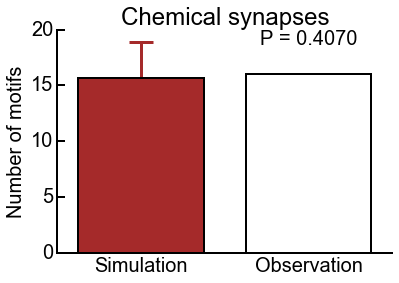

In [49]:
# This is our null hypothesis
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_chem, n_found = mydataset.motif.ii_chem_found);
ax.set_title('Chemical synapses');
ax.set_ylim(ymax=20);

#fig.savefig('ii_chem.pdf')

<H2>Plot electrical synapses alone </H2>

(0.0, 20)

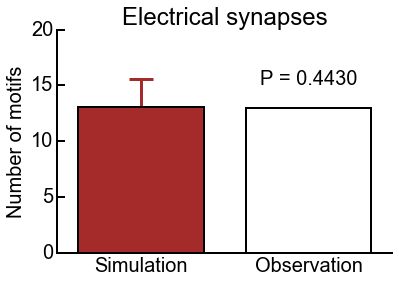

In [50]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_elec, n_found = mydataset.motif.ii_elec_found);
ax.set_title('Electrical synapses');
ax.set_ylim(ymax=20);

#fig.savefig('ii_elec.pdf')

<H2>Plot bidirectional chemical synapses</H2>


(0.0, 10)

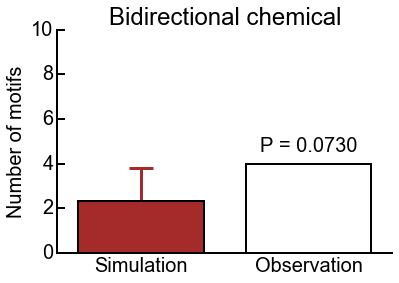

In [51]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2, n_found = mydataset.motif.ii_c2_found);
ax.set_title('Bidirectional chemical');
ax.set_ylim(ymax=10);

#fig.savefig('ii_c2.pdf')

<H2>Plot convergent inhibitory</H2>

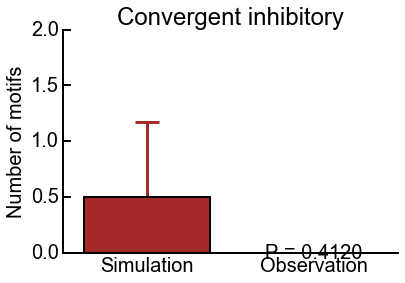

In [52]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_con, n_found = mydataset.motif.ii_con_found);
ax.set_title('Convergent inhibitory');
ax.set_ylim(ymin=0, ymax=2);


<H2> Plot divergent inhibitory </H2>

(0, 5)

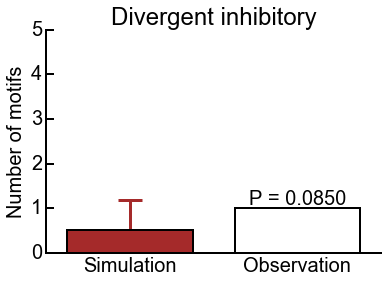

In [53]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_div, n_found = mydataset.motif.ii_div_found);
ax.set_title('Divergent inhibitory');
ax.set_ylim(ymin=0, ymax=5);

#fig.savefig('ii_c1e.pdf')

<H2>Plot linear chains</H2>

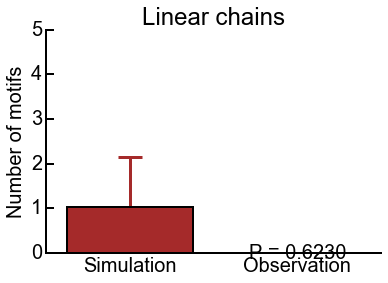

In [54]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_chain, n_found = mydataset.motif.ii_chain_found);
ax.set_title('Linear chains');
ax.set_ylim(ymin=0, ymax=5);


<H2>Plot electrical and one chemical synapse alone </H2>

(0.0, 12)

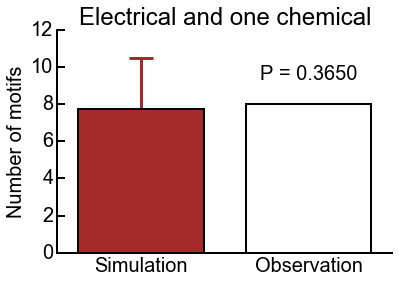

In [55]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c1e, n_found = mydataset.motif.ii_c1e_found);
ax.set_title('Electrical and one chemical');
ax.set_ylim(ymax=12);

#fig.savefig('ii_c1e.pdf')

<H2>Plot electrical and two chemical</H2>

(0, 5)

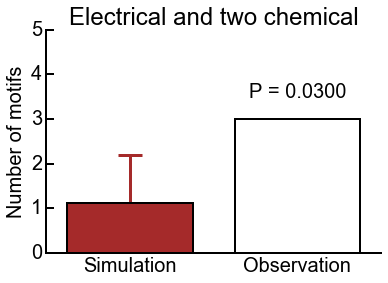

In [56]:
fig = figure(5)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2e, n_found = mydataset.motif.ii_c2e_found);
ax.set_title('Electrical and two chemical');
ax.set_ylim(ymin  = 0, ymax=5);

#fig.savefig('ii_c2d.pdf')